In [1]:
import requests
import bs4 as bs
import pandas as pd
import numpy as np
import warnings
import re
import datetime
import time
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function, division, absolute_import #make compatible with Python 2 and Python 3

In [2]:
#Scraping code for InvestFeed
record = pd.DataFrame()
for i in range(0,303):
    post=[]
    date=[]
    url = "https://www.investfeed.com/currency/BTC?page="+str(i)
    soup = bs.BeautifulSoup(requests.get(url).text, "html.parser")
    content = soup.find_all('div', attrs={'class': 'post-content'})
    date_time = soup.find_all('div',attrs={'class':'floated-right'})
    for x in range(len(content)):
        post.append(re.sub(r'\s+', ' ', content[x].text))
        date.append(re.sub(r'\s+',' ',date_time[x].text))
    if (i+1)%25 == 0:
        print('{} pages completed!'.format(i+1))
    t1 = pd.Series(date)
    t2 = pd.Series(post)
    temp_record = pd.concat([t1,t2],axis=1)
    record = pd.concat([record,temp_record]).reset_index(drop=True)

25 pages completed!
50 pages completed!
75 pages completed!
100 pages completed!
125 pages completed!
150 pages completed!
175 pages completed!
200 pages completed!
225 pages completed!
250 pages completed!
275 pages completed!
300 pages completed!


In [3]:
record.shape

(3030, 2)

In [131]:
#record = record.drop(record[record.index > 2264].index) #Elements beyond this had random content. 2264 captures all posts.

In [7]:
record = record.rename(columns = {0:'Date',1:'Post'})

In [8]:
record['Date'] = pd.to_datetime(record['Date']).dt.date #Converting from str to datetime obj and retaining just the dates

In [14]:
record.head(21)

,Date,Post
0,2018-01-22,Weekly Review in Crypto January 22nd. Here is...
1,2018-01-22,http://ifeed.io/HJjWw #Crypto #Cryptocurrency...
2,2018-01-22,Free Airdrop Get $5 worth free $CCRB for just...
3,2018-01-22,The Crypto top 10 by market cap is up and dow...
4,2018-01-22,Sent $BTC last night. Super fast - less than ...
5,2018-01-22,Use the coupon code: OPEN18! to receive a 20%...
6,2018-01-22,Everyday Above Ground Is A Good Day.... #XRP ...
7,2018-01-22,"Boy does it feel good to buy $VEN at 7,404 sa..."
8,2018-01-22,http://ifeed.io/EkCx1 Bitcoin Mining Contract...
9,2018-01-22,Coin of the Day: #EOS Enjoy! http://ifeed.io/...


In [15]:
record = record.iloc[20:].reset_index(drop=True) #Prices unavailable for Novmeber 30th

In [16]:
record.head()

,Date,Post
0,2018-01-21,Bull flag on $BTC I think we are going to bou...
1,2018-01-21,#BTC IS KING!
2,2018-01-21,Have a great weekend everybody! #bitcoin #eth...
3,2018-01-21,Hello Investfeed and my fellow coin nerds!! W...
4,2018-01-21,Once This Happens Cardano Will Go To The Moon...


In [17]:
col_names = ['Date','Price']
btc = pd.read_csv('btc_price.csv',header=None,names=col_names)

In [48]:
print(btc.shape)
btc.head()

(365, 3)


,Date,Price,Sentiment
0,2017-01-22,918.603625,0
1,2017-01-23,922.073612,1
2,2017-01-24,890.320225,0
3,2017-01-25,893.045625,1
4,2017-01-26,915.956250,1


In [49]:
#Setting labels for the Bitcoin prices to perform Sentiment Analysis
label=[]
for i in range(1,btc.shape[0]):
    if (btc.iat[i,1]>btc.iat[i-1,1]):
        btc.loc[btc.index[i],'Sentiment']=1
    else:
        btc.loc[btc.index[i],'Sentiment']=0
btc.loc[btc.index[0],'Sentiment']=0 #To match indices with btc. This false value will anyway go away when we trim BTC to match record df.
btc['Sentiment'] = btc['Sentiment'].astype(int)

In [50]:
btc['Date'] = pd.to_datetime(btc['Date']).dt.date

In [51]:
btc.head()

,Date,Price,Sentiment
0,2017-01-22,918.603625,0
1,2017-01-23,922.073612,1
2,2017-01-24,890.320225,0
3,2017-01-25,893.045625,1
4,2017-01-26,915.956250,1


In [52]:
temp = record.merge(btc, on='Date', how='inner')

In [53]:
sent = temp.drop('Price',1)

In [54]:
sent.head()

,Date,Post,Sentiment
0,2018-01-21,Bull flag on $BTC I think we are going to bou...,0
1,2018-01-21,#BTC IS KING!,0
2,2018-01-21,Have a great weekend everybody! #bitcoin #eth...,0
3,2018-01-21,Hello Investfeed and my fellow coin nerds!! W...,0
4,2018-01-21,Once This Happens Cardano Will Go To The Moon...,0


In [55]:
sent.shape

(3010, 3)

1    1807
0    1203
Name: Sentiment, dtype: int64


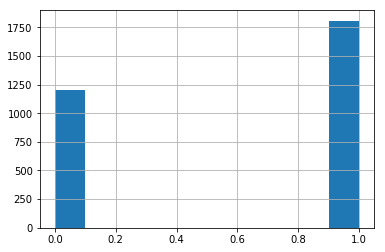

In [56]:
print(sent.Sentiment.value_counts())
sent.Sentiment.hist(); 

In [57]:
#Apply length function to the review column
lengths = sent.Post.apply(len)

print('Average character length of the posts are:')
print (np.mean(lengths))

Average character length of the posts are:
251.68504983388704


# NLP

In [58]:
import nltk
#nltk.download()

In [59]:
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

eng = stopwords.words('English')

In [33]:
test_post = sent['Post'][0]# the review used for initial analysis
print(test_post)

 Bull flag on $BTC I think we are going to bounce around in here for a while. Alts most likely will flourish. Ill only become bearish if we close below the channel on the 1 day. But it seems like strong support #HODL #BTC (Im new to investfeed I hope im doing this right 😬) 


In [34]:
print(len(sent_tokenize(test_post)))
sent_tokenize(test_post) # doesn't really split all sentences

4


[' Bull flag on $BTC I think we are going to bounce around in here for a while.',
 'Alts most likely will flourish.',
 'Ill only become bearish if we close below the channel on the 1 day.',
 'But it seems like strong support #HODL #BTC (Im new to investfeed I hope im doing this right 😬)']

In [35]:
# Check if it does a better job if we add space after every period
test_post = test_post.replace('.','. ')

print(len(sent_tokenize(test_post)), end='\n\n') # number of sentences

# print all sentences on a new line
for sent in sent_tokenize(test_post):
    print(sent, end='\n\n')

4

 Bull flag on $BTC I think we are going to bounce around in here for a while.

Alts most likely will flourish.

Ill only become bearish if we close below the channel on the 1 day.

But it seems like strong support #HODL #BTC (Im new to investfeed I hope im doing this right 😬)



In [36]:
test_post = re.sub('[^a-zA-Z]',' ',test_post)
print(test_post) # remove special character

 Bull flag on  BTC I think we are going to bounce around in here for a while   Alts most likely will flourish   Ill only become bearish if we close below the channel on the   day   But it seems like strong support  HODL  BTC  Im new to investfeed I hope im doing this right    


In [37]:
test_post = test_post.lower()

In [38]:
test_post

' bull flag on  btc i think we are going to bounce around in here for a while   alts most likely will flourish   ill only become bearish if we close below the channel on the   day   but it seems like strong support  hodl  btc  im new to investfeed i hope im doing this right    '

In [39]:
test_post_words = test_post.split()
print(test_post_words[:10]) # tokenize and lower case
print(len(test_post_words))

['bull', 'flag', 'on', 'btc', 'i', 'think', 'we', 'are', 'going', 'to']
53


In [40]:
ps = PorterStemmer() #initialize Porter Stemmer object

ps_stems = []
for w in test_post_words:
    ps_stems.append(ps.stem(w))

print(' '.join(ps_stems)) # add all the stemmed words to one string

bull flag on btc i think we are go to bounc around in here for a while alt most like will flourish ill onli becom bearish if we close below the channel on the day but it seem like strong support hodl btc im new to investfe i hope im do thi right


In [41]:
#parts of speech tagging

token_tag = pos_tag(test_post_words)
token_tag[:10]

[('bull', 'NN'),
 ('flag', 'NN'),
 ('on', 'IN'),
 ('btc', 'NN'),
 ('i', 'NN'),
 ('think', 'VBP'),
 ('we', 'PRP'),
 ('are', 'VBP'),
 ('going', 'VBG'),
 ('to', 'TO')]

In [42]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [295]:
#from nltk.stem import WordNetLemmatizer


wnl = WordNetLemmatizer()

wnl_stems = []
for pair in token_tag:
    res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
    wnl_stems.append(res)

print(' '.join(wnl_stems))

btc we hit short term resistance today and be now hit the upper breakout trend line the daily and hourly chart be signal a potential short term reversal so i would look to sell short term breakout unless we get a nice reversal back above if you like my analysis and it help a tip would be appreciate cheer etc eth ltc


In [45]:
def post_cleaner(post):
    
    #1. Use regex to find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', post)
    
    #2. Remove punctuation
    post = re.sub("[^a-zA-Z]", " ",post)
    
    #3. Tokenize into words (all lower case)
    post = post.lower().split()
    
    #4. Remove stopwords
    eng_stopwords = set(stopwords.words("english"))
    post = [w for w in post if not w in eng_stopwords]
    
    #5. Join the review to one sentence
    post = ' '.join(post+emoticons)
    # add emoticons to the end

    return(post)

In [60]:
%%time

num_posts = len(sent['Post'])

post_clean_original = []

for i in range(0,num_posts):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d posts" %(i+1)) 
    post_clean_original.append(post_cleaner(record['Post'][i]))

Done with 500 posts
Done with 1000 posts
Done with 1500 posts
Done with 2000 posts
Done with 2500 posts
Done with 3000 posts
CPU times: user 651 ms, sys: 588 ms, total: 1.24 s
Wall time: 1.24 s


In [67]:
%%time
# Lemmatizer

post_clean_wnl = []

wnl = WordNetLemmatizer()

for i in range(0,num_posts):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d posts" %(i+1)) 
    
    wnl_stems = []
    token_tag = pos_tag(post_clean_original[i].split())
    for pair in token_tag:
        res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
        wnl_stems.append(res)

    post_clean_wnl.append(' '.join(wnl_stems))

Done with 500 posts
Done with 1000 posts
Done with 1500 posts
Done with 2000 posts
Done with 2500 posts
Done with 3000 posts
CPU times: user 7.32 s, sys: 378 ms, total: 7.7 s
Wall time: 7.83 s


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split

# put everything together in a function

def predict_sentiment(cleaned_posts, y=sent["Sentiment"]):

    print("Creating the bag of words model..\n")
    # CountVectorizer" is scikit-learn's bag of words tool, here we show more keywords 
    bigram_vectorizer = CountVectorizer(analyzer = "word",   \
                                 ngram_range=(1,2),    \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 2000) 
    
    X_train, X_test, y_train, y_test = train_test_split(\
    cleaned_posts, y, random_state=0, test_size=0.2)

    # Then we use fit_transform() to fit the model / learn the vocabulary,
    # then transform the data into feature vectors.
    # The input should be a list of strings. .toarraty() converts to a numpy array
    
    train_bag = bigram_vectorizer.fit_transform(X_train).toarray()
    test_bag = bigram_vectorizer.transform(X_test).toarray()

    # You can extract the vocabulary created by CountVectorizer
    # by running print(vectorizer.get_feature_names())


    print("Training the random forest classifier..\n")
    # Initialize a Random Forest classifier with 75 trees
    forest = RandomForestClassifier(n_estimators = 50) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the target variable
    forest = forest.fit(train_bag, y_train)


    train_predictions = forest.predict(train_bag)
    test_predictions = forest.predict(test_bag)
    
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    print("The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", valid_acc)
    print()
    print()
    #Extract feature importnace
    print('TOP TEN IMPORTANT FEATURES:')
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_10 = indices[:15]
    print([bigram_vectorizer.get_feature_names()[ind] for ind in top_10])

In [70]:
predict_sentiment(post_clean_original) #Accuracy measure with original sentences

Creating the bag of words model..

Training the random forest classifier..

The training accuracy is:  0.985880398671 
 The validation accuracy is:  0.599667774086


TOP TEN IMPORTANT FEATURES:
['bitcoin', 'cryptocurrency', 'btc', 'crypto', 'bch', 'ifeed', 'soon', 'ift', 'http ifeed', 'eth', 'btc ift', 'investfeed', 'like', 'http', 'fud']


In [71]:
predict_sentiment(post_clean_wnl) #Lemmatized sentences lead to lower accuracy

Creating the bag of words model..

Training the random forest classifier..

The training accuracy is:  0.985880398671 
 The validation accuracy is:  0.563122923588


TOP TEN IMPORTANT FEATURES:
['bitcoin', 'cryptocurrency', 'btc', 'bch', 'crypto', 'io', 'soon', 'eth', 'get', 'btc ift', 'coin', 'fud', 'go', 'investfeed', 'ico']
